Making a rougth SED for a talk, seeing which of the gjs (all data already in) looks best.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

In [4]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/'
gjs = ['gj341', 'gj367']

gj341
/media/david/2tb_ext_hd/hddata/meats/hst/gj341/oeoo05010_x1d.fits
G140M
/media/david/2tb_ext_hd/hddata/meats/hst/gj341/oeoo05020_x1d.fits
G230L
/media/david/2tb_ext_hd/hddata/meats/hst/gj341/oeoo05030_sx1.fits
G430L
/media/david/2tb_ext_hd/hddata/meats/hst/gj341/leoo06010_x1dsum.fits
G130M


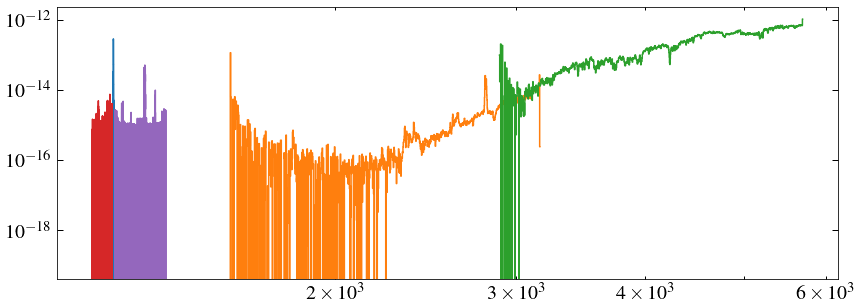

gj367
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/oeoo03010_x1d.fits
G140M
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/oeoo03020_x1d.fits
G230L
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/oeoo03030_sx1.fits
G430L
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/leoo04010_x1dsum.fits
G130M


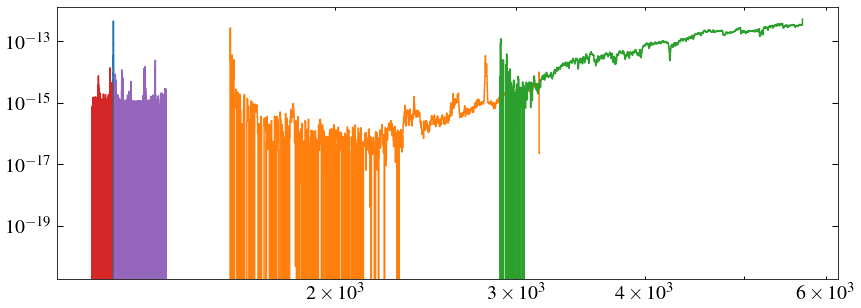

In [20]:
for gj in gjs:
    print(gj)
    x1ds = np.hstack((glob.glob('{}{}/*0_x1d.fits'.format(path, gj)), glob.glob('{}{}/*sx1.fits'.format(path, gj)), glob.glob('{}{}/*x1dsum.fits'.format(path, gj))))
    # print(x1ds)
    for x in x1ds:
        print(x)
        alldata = fits.getdata(x, 1)
        hdr = fits.getheader(x,0)
        print(hdr['OPT_ELEM'])
        for data in alldata[::-1]:
            w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
            mask = w > 1160
            w, f, e = w[mask], f[mask], e[mask]
            plt.step(w, f, where='mid')
            # plt.step(w, e, where='mid')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [47]:
# #quick (maybe better) remove negs code? (nope)
# def remove_negatives(f):
#     fnew = f
#     nneg = len(fnew[fnew < 0])
#     i = 0
#     while nneg > 0 and i < 10:
#         minarg = np.argmin(fnew)
#         print(minarg)
#         if minarg == 0:
#             fnew[minarg:minarg+2] = np.mean(fnew[minarg:minarg+2])
#         elif minarg == len(fnew) -1:
#             fnew[minarg-1:minarg+1] = np.mean(fnew[minarg-1:minarg+1])
#         else:
#             print(fnew[minarg-1:minarg+2])
#             fnew[minarg-1:minarg+2] = np.mean(fnew[minarg-1:minarg+2])
#             print(fnew[minarg-1:minarg+2])
            
#         nneg = len(fnew[fnew < 0])
#         print(nneg)
#         i +=1
#     return fnew    
    

In [48]:
# fnew = remove_negatives(f)
# plt.plot(w, f)
# plt.plot(w, fnew)

gj341
/media/david/2tb_ext_hd/hddata/meats/hst/gj341/oeoo05010_x1d.fits
G140M
/media/david/2tb_ext_hd/hddata/meats/hst/gj341/oeoo05020_x1d.fits
G230L
/media/david/2tb_ext_hd/hddata/meats/hst/gj341/oeoo05030_sx1.fits
G430L
/media/david/2tb_ext_hd/hddata/meats/hst/gj341/leoo06010_x1dsum.fits
G130M


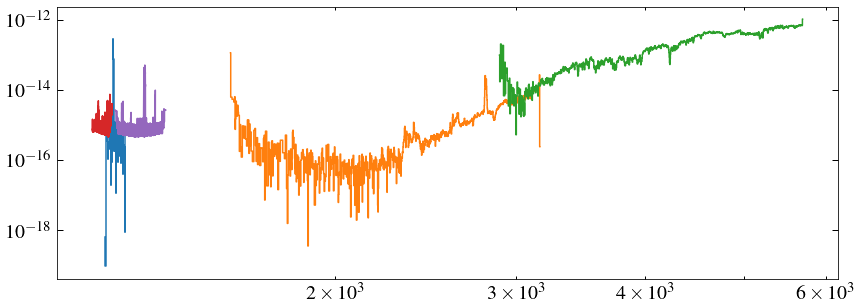

gj367
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/oeoo03010_x1d.fits
G140M
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/oeoo03020_x1d.fits
G230L
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/oeoo03030_sx1.fits
G430L
/media/david/2tb_ext_hd/hddata/meats/hst/gj367/leoo04010_x1dsum.fits
G130M


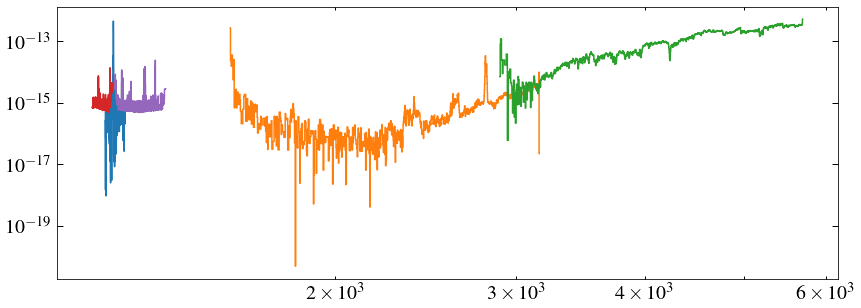

In [57]:
for gj in gjs:
    print(gj)
    x1ds = np.hstack((glob.glob('{}{}/*0_x1d.fits'.format(path, gj)), glob.glob('{}{}/*sx1.fits'.format(path, gj)), glob.glob('{}{}/*x1dsum.fits'.format(path, gj))))
    # print(x1ds)
    for x in x1ds:
        print(x)
        alldata = fits.getdata(x, 1)
        hdr = fits.getheader(x,0)
        print(hdr['OPT_ELEM'])
        wmax = 0
        for data in alldata[::-1]:
            w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
            mask = (w > 1160) & (w > wmax) & (f > 0)
            w, f, e = w[mask], f[mask], e[mask]
            plt.step(w, f, where='mid')
            if max(w) > wmax:
                wmax = max(w)
            # plt.step(w, e, where='mid')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()